## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.plots import *
from pycocotools.coco import COCO

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [88]:
from sklearn.metrics import fbeta_score

In [89]:
def f1(preds, targs, th):
    return fbeta_score(targs, (preds>th), 1, average='samples')

In [3]:
PATH = Path('../data/coco/')

## Multi-label models for Planet dataset

In [4]:
coco_trn = COCO(PATH/'annotations/instances_train2017.json')
coco_val = COCO(PATH/'annotations/instances_val2017.json')

loading annotations into memory...
Done (t=16.73s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [5]:
all_img_ids_trn = coco_trn.getImgIds()
all_img_ids_val = coco_val.getImgIds()

In [53]:
def create_ml_csv(im_ids, coco_ob, parent_dir=None):
    labels_list = []
    fn_list = []
    for imx in im_ids:
        im_ob = coco_ob.loadImgs(imx)[0]
        annIds = coco_ob.getAnnIds(imgIds=im_ob['id'], iscrowd=None)
        anns = coco_ob.loadAnns(annIds)
        label_set = set([ann['category_id'] for ann in anns])
        cat_obs = coco_ob.loadCats(label_set)
        cats = [cat_ob['name'].replace(' ', '_') for cat_ob in cat_obs]
        cat_string = ' '.join(cats)
        labels_list.append(cat_string)
        if parent_dir: 
            fn = f'{parent_dir}/{im_ob["file_name"]}' 
        else:
            fn = im_ob['file_name']
        fn_list.append(fn)
    
    df = pd.DataFrame({'fn': fn_list, 'clas': labels_list}, columns=['fn','clas'])
    return df

In [54]:
df_train = create_ml_csv(all_img_ids_trn, coco_trn, 'train2017')
df_valid = create_ml_csv(all_img_ids_val, coco_val, 'val2017')

In [44]:
n_train = len(df_train)
n_valid = len(df_valid)

In [55]:
df_all = pd.concat([df_train, df_valid])

In [56]:
df_all.to_csv(PATH/'ml_anns.csv', index=False)

In [41]:
arch = resnet18

In [47]:
label_csv = PATH/'ml_anns.csv'
val_idxs = np.arange(n_train, n_train+n_valid)

In [52]:
!ls {PATH}

annotations    hotdogs_valid  person_mask_train  train2017     valid_ml.csv
deploy_models  ml_anns.csv    person_mask_val	 train_ml.csv
hotdogs_train  models	      tmp		 val2017


In [70]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, '', label_csv, tfms=tfms,
                                        val_idxs=val_idxs, bs=bs, num_workers=8)

In [61]:
data = get_data(128)

In [62]:
x,y = next(iter(data.val_dl))

In [64]:
list(zip(data.classes, y[0]))

[('airplane', 0.0),
 ('apple', 0.0),
 ('backpack', 0.0),
 ('banana', 0.0),
 ('baseball_bat', 0.0),
 ('baseball_glove', 0.0),
 ('bear', 0.0),
 ('bed', 0.0),
 ('bench', 0.0),
 ('bicycle', 0.0),
 ('bird', 0.0),
 ('boat', 0.0),
 ('book', 0.0),
 ('bottle', 1.0),
 ('bowl', 1.0),
 ('broccoli', 1.0),
 ('bus', 0.0),
 ('cake', 0.0),
 ('car', 0.0),
 ('carrot', 1.0),
 ('cat', 0.0),
 ('cell_phone', 0.0),
 ('chair', 0.0),
 ('clock', 0.0),
 ('couch', 0.0),
 ('cow', 0.0),
 ('cup', 1.0),
 ('dining_table', 1.0),
 ('dog', 0.0),
 ('donut', 0.0),
 ('elephant', 0.0),
 ('fire_hydrant', 0.0),
 ('fork', 0.0),
 ('frisbee', 0.0),
 ('giraffe', 0.0),
 ('hair_drier', 0.0),
 ('handbag', 0.0),
 ('horse', 0.0),
 ('hot_dog', 0.0),
 ('keyboard', 0.0),
 ('kite', 0.0),
 ('knife', 1.0),
 ('laptop', 0.0),
 ('microwave', 0.0),
 ('motorcycle', 0.0),
 ('mouse', 0.0),
 ('orange', 0.0),
 ('oven', 1.0),
 ('parking_meter', 0.0),
 ('person', 1.0),
 ('pizza', 0.0),
 ('potted_plant', 0.0),
 ('refrigerator', 0.0),
 ('remote', 0.0),
 (

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


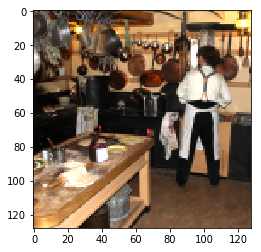

In [65]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [71]:
sz=64

In [76]:
data = get_data(sz, bs=128)

In [77]:
data = data.resize(int(sz*1.3), 'tmp')

In [78]:
learn = ConvLearner.pretrained(arch, data)

epoch      trn_loss   val_loss   <lambda>   
    0      0.112414   0.103347   0.96764   


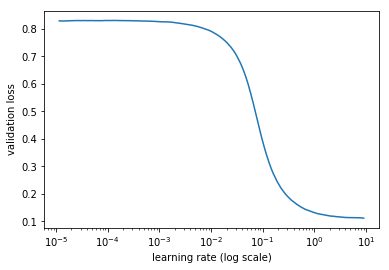

In [79]:
lrf=learn.lr_find()
learn.sched.plot()

In [80]:
lr = 2e-1

In [81]:
learn.fit(lr, 1, cycle_len=8, use_clr=(10,10))

epoch      trn_loss   val_loss   <lambda>   
    0      0.109999   0.101241   0.968142  
    1      0.104885   0.097173   0.968857  
    2      0.103442   0.095682   0.969028  
    3      0.100824   0.095083   0.969222  
    4      0.101217   0.094599   0.969268  
    5      0.100439   0.0942     0.969373  
    6      0.099533   0.093958   0.969375  
    7      0.100471   0.093974   0.96945   


[array([0.09397]), 0.9694500058174134]

In [82]:
learn.save(f'multilabel_{sz}_last')

In [117]:
lrs = np.array([lr/100,lr/10,lr])

In [118]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>   
    0      0.102086   0.095587   0.969075  
    1      0.096139   0.091339   0.97      
    2      0.094298   0.090617   0.97021   
    3      0.092649   0.08851    0.970615  
    4      0.092311   0.087255   0.970995  
    5      0.091159   0.08687    0.971035  
    6      0.090302   0.086737   0.971115  


[array([0.08674]), 0.9711149993896484]

In [119]:
learn.save(f'multilabel_{sz}_all')

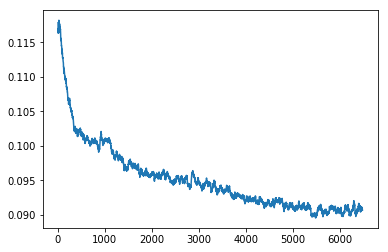

In [120]:
learn.sched.plot_loss()

In [121]:
pred = learn.predict()

In [124]:
fbeta_score(data.val_ds.y, pred>0.3, beta=1, average='samples')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


0.4782728261078746

In [122]:
list(zip(learn.data.classes, fbeta_score(data.val_ds.y, pred>0.5, beta=1, average=None)))

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[('airplane', 0.5625000000000001),
 ('apple', 0.18181818181818182),
 ('backpack', 0.0),
 ('banana', 0.12389380530973451),
 ('baseball_bat', 0.49367088607594944),
 ('baseball_glove', 0.6857142857142857),
 ('bear', 0.4126984126984127),
 ('bed', 0.2702702702702703),
 ('bench', 0.0),
 ('bicycle', 0.0),
 ('bird', 0.0),
 ('boat', 0.36942675159235666),
 ('book', 0.10116731517509728),
 ('bottle', 0.049999999999999996),
 ('bowl', 0.14730878186968838),
 ('broccoli', 0.6194690265486726),
 ('bus', 0.42968749999999994),
 ('cake', 0.0),
 ('car', 0.34547908232118757),
 ('carrot', 0.024096385542168672),
 ('cat', 0.28695652173913044),
 ('cell_phone', 0.0),
 ('chair', 0.3072847682119205),
 ('clock', 0.41635687732342014),
 ('couch', 0.2975206611570248),
 ('cow', 0.04395604395604396),
 ('cup', 0.27530364372469635),
 ('dining_table', 0.4717948717948718),
 ('dog', 0.08602150537634408),
 ('donut', 0.0),
 ('elephant', 0.49230769230769234),
 ('fire_hydrant', 0.06666666666666667),
 ('fork', 0.13259668508287295)

In [125]:
f1(pred, data.val_y, 0.3)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


0.4782728261078746

In [ ]:
list(zip(learn.data.classes,np.mean(data.val_y, 0)))

In [126]:
learn.data.path

'../data/coco/tmp/83'

In [127]:
sz=128

In [143]:
data = get_data(sz, 64)
data = data.resize(int(sz*1.3),resume=True)

In [144]:
learn.set_data(data)
learn.freeze()

epoch      trn_loss   val_loss   <lambda>   
    0      0.09295    0.088393   0.9713    


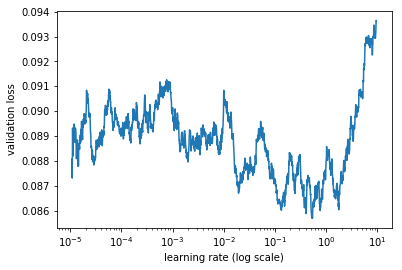

In [130]:
lrf=learn.lr_find()
learn.sched.plot()

In [148]:
lr=1e-2
lrs = np.array([lr/100,lr/10,lr])

In [147]:
learn.fit(lr, 1, cycle_len=5, use_clr=(10,10))

epoch      trn_loss   val_loss   <lambda>   
    0      0.088376   0.082513   0.972005  
    1      0.08739    0.08195    0.972198  
    2      0.086557   0.081424   0.972263  
    3      0.088062   0.081331   0.972358  
    4      0.088076   0.081054   0.972462  


[array([0.08105]), 0.9724624961853028]

In [149]:
learn.save(f'multilabel_{sz}_last')

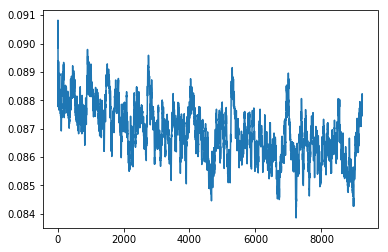

In [151]:
learn.sched.plot_loss()

In [152]:
learn.unfreeze()

In [153]:
learn.fit(lrs, 1, cycle_len=5, use_clr=(10,10))

epoch      trn_loss   val_loss   <lambda>   
    0      0.083226   0.07756    0.973418  
    1      0.082732   0.076849   0.973587  
    2      0.081116   0.076493   0.973725  
    3      0.082381   0.076259   0.973808  
    4      0.081436   0.076064   0.973782  


[array([0.07606]), 0.9737824974060059]

In [154]:
learn.save(f'multilabel_{sz}_all')

In [155]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [159]:
from sklearn.metrics import precision_recall_fscore_support

In [158]:
f1(preds, y, 0.3)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


0.5589507558018177

In [162]:
precision_recall_fscore_support(y, preds>0.25, average='samples')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


(0.6289435697635698, 0.5993207803307803, 0.5722610275680109, None)

In [163]:
sz=256

In [164]:
data=get_data(sz,64)

In [165]:
data = data.resize(int(1.3*sz))

In [166]:
learn.set_data(data)

In [167]:
learn.freeze()

epoch      trn_loss   val_loss   <lambda>   
    0      0.085057   0.076448   0.97405   


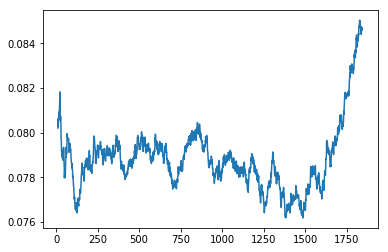

In [168]:
learn.lr_find()
learn.sched.plot()

In [170]:
lr=1e-2
lrs=np.array([lr/100,lr/10,lr])

In [171]:
learn.fit(lr, 1, cycle_len=5, use_clr=(10,10))

epoch      trn_loss   val_loss   <lambda>   
    0      0.078643   0.073443   0.974365  
  8%|▊         | 144/1849 [01:29<17:38,  1.61it/s, loss=0.0775]

KeyboardInterrupt: 

In [172]:
learn.save(f'multilabel_{sz}_last')